## Local ADCP Particle test with CMEMS data

### Use interactive map to determine ship course 

In [1]:
import leafmap
import numpy as np
import matplotlib.pyplot as plt 
import geojson
from shapely.geometry.polygon import Polygon
from shapely.geometry import shape, Point

In [2]:
m = leafmap.leafmap.Map(center=(50, 5), zoom=4)
m

Map(center=[50, 5], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

In [3]:
m.save_draw_features("data.geojson")
with open('./data.geojson') as f:
    gj = geojson.load(f)
features = gj['features']
shapes = []
for feature in features:
  shapes.append(shape(feature['geometry']))
for set_shape in shapes:
  print(set_shape)

LINESTRING (-2.197266 49.781264, -35.595703 39.97712, -33.046875 38.134557, -30.146484 36.315125, -27.509766 35.101934, -23.994141 35.317366, -22.5 37.857507, -24.433594 39.639538, -26.982422 41.178654, -9.667969 43.325178)


In [4]:
lons = []
lats = []

npts_line = 1
# npts_box = 2000

for set_shape in shapes:
  # If the release location is a point
  if set_shape.type.lower() == 'point':
    lons.append(set_shape.coords.xy[0][0])
    lats.append(set_shape.coords.xy[1][0])
  # If the release location is a linestring (could be multiple lines)
  elif set_shape.type.lower() == 'linestring':
    pointlist_lon = set_shape.coords.xy[0]
    pointlist_lat = set_shape.coords.xy[1]

    for i in range(len(pointlist_lon)-1):
      point1 = [pointlist_lon[i], pointlist_lat[i]]
      point2 = [pointlist_lon[i+1], pointlist_lat[i+1]]

      lons.append(np.linspace(point1[0], point2[0], npts_line, endpoint=True))
      lats.append(np.linspace(point1[1], point2[1], npts_line, endpoint=True))
  # # If the release location is a polygon
  # elif set_shape.type.lower() == 'polygon':
  #   #Place a box over, then only keep points in box
  #   bounds = set_shape.bounds

  #   vec = np.linspace(0, 1, int(np.sqrt(npts_box)+1))
  #   xsi, eta = np.meshgrid(vec, vec)
  #   lonCorners = [bounds[0], bounds[2], bounds[2], bounds[0]]
  #   latCorners = [bounds[1], bounds[1], bounds[3], bounds[3]]

  #   lon = (1-xsi)*(1-eta) * lonCorners[0] + xsi*(1-eta) * lonCorners[1] + \
  #       xsi*eta * lonCorners[2] + (1-xsi)*eta * lonCorners[3]
  #   lat = (1-xsi)*(1-eta) * latCorners[0] + xsi*(1-eta) * latCorners[1] + \
  #       xsi*eta * latCorners[2] + (1-xsi)*eta * latCorners[3]

  #   lon = lon.flatten()
  #   lat = lat.flatten()
  #   # Keep points in polygon
  #   keep = []
  #   for i in range(len(lon)):
  #       point = Point(lon[i], lat[i])
  #       if set_shape.contains(point):
  #         keep.append(i)

  #   lons.append(lon[keep])
  #   lats.append(lat[keep])

lons = np.hstack(np.asarray(lons))
lats = np.hstack(np.asarray(lats))

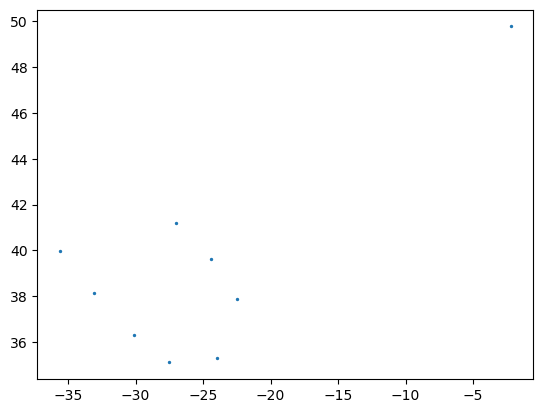

In [5]:
plt.scatter(lons, lats, s=2)
plt.show()

### Compute distance travelled by ship

In [ ]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

### Read sample input data

In [15]:
from datetime import timedelta
import math

from parcels import (
    AdvectionRK4,
    ErrorCode,
    FieldSet,
    JITParticle,
    ParticleSet,
    Variable,
)

In [18]:
# Load the CMEMS data (3 days manually downloaded)
example_dataset_folder = "../Data"
filenames = {
    "U": f"{example_dataset_folder}/glo12_rg_1d-m_2021010*_3D-uovo_hcst_R20210113.nc",
    "V": f"{example_dataset_folder}/glo12_rg_1d-m_2021010*_3D-uovo_hcst_R20210113.nc",
    "S": f"{example_dataset_folder}/glo12_rg_1d-m_2021010*_3D-so_hcst_R20210113.nc",
    "T": f"{example_dataset_folder}/glo12_rg_1d-m_2021010*_3D-thetao_hcst_R20210113.nc",
}
variables = {'U': 'uo', 'V': 'vo', 'S':'so', 'T':'thetao'}
dimensions = {'lon': 'longitude', 'lat': 'latitude', 'time': 'time', 'depth':'depth'}
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, time_periodic=timedelta(days=3))

# uppermost layer in the hydrodynamic data
fieldset.mindepth = fieldset.U.depth[0]
print(fieldset.mindepth)

# set initial location
ini_lat = -31
ini_lon = 32

0.494025


### Create particles and initalize

In [19]:
# Create and initialize Variable particles to sample the ocean
class SampleParticleInitZero(JITParticle):
    """Define a new particle class with Variables init 0"""
    salinity = Variable("salinity", initial=0)
    temperature = Variable("temperature", initial=0)
    U = Variable('U', dtype=np.float32, initial=np.nan)
    V = Variable('V', dtype=np.float32, initial=np.nan)

# define function sampling Salinity 
def SampleS(particle, fieldset, time):
    particle.salinity = fieldset.S[time, particle.depth, particle.lat, particle.lon]

# define function sampling Temperature 
def SampleT(particle, fieldset, time):
    particle.temperature = fieldset.T[time, particle.depth, particle.lat, particle.lon]

# define function sampling u and v as in https://docs.oceanparcels.org/en/latest/examples/tutorial_sampling.html
def SampleVel_correct(particle, fieldset, time):
    particle.U, particle.V = fieldset.UV[time, particle.depth, particle.lat, particle.lon, particle]

# Attempt for ADCP like particle TODO accurate depths TODO max depth/bathymetry
depthnum = 10
# Initiate ADCP like particle set 
pset = ParticleSet.from_list(
    fieldset=fieldset, pclass=SampleParticleInitZero, lon=np.full(depthnum,ini_lon), lat=np.full(depthnum,ini_lat), depth=np.linspace(5, 1000, num=depthnum)
)

Sample_S_kernel = pset.Kernel(SampleS)  # Casting the SampleS function to a kernel.
Sample_T_kernel = pset.Kernel(SampleT)  # similar for temperature
SampleVel_kernel = pset.Kernel(SampleVel_correct)  # Casting the function to a kernel.

# only execute the sampling kernels to record the init values of the particles
pset.execute(Sample_S_kernel, dt=0)
pset.execute(Sample_T_kernel, dt=0)
pset.execute(SampleVel_correct, dt=0)

INFO: Compiled ArraySampleParticleInitZeroSampleS ==> /tmp/parcels-382783/lib9c185e43a28f643c3869bdd65dc6c308_0.so
INFO: Compiled ArraySampleParticleInitZeroSampleT ==> /tmp/parcels-382783/lib88d94be9f8f724380c265548a5eb9e7d_0.so


### Determine ship course and add as kernel 

In [42]:
# change advection to ship movement
# Cruising speed Pelagia (and Anna Weber) is 9 knp https://www.nioz.nl/application/files/3614/9744/8746/Pelagia_Technical_specifications-2016.pdf
# survey speed nog iets lager? Zoals bij https://schmidtocean.org/rv-falkor/ship-specifications/
# 7 knp = 13 km/h = 3.6 m/s

def ShipVel(particle, fieldset, time):
    speed = 3.6
    target_lat = -50
    target_lon = 20
    # determine ship direction
    heading = math.sqrt((target_lat - particle.lat)**2 + (target_lon - particle.lon)**2)
    # calculate e/w and n/s speed (m/s)
    lat_add = (target_lat - particle.lat)/(heading/speed)
    lon_add = (target_lon - particle.lon)/(heading/speed)
    # convert to lat/lon
    lat_add_deg = lat_add / 1.11e5
    lon_add_deg = lon_add / (1.11e5 * math.cos(particle.lat * math.pi / 180))
    # add to particle position
    particle.lat += lat_add_deg * particle.dt
    particle.lon += lon_add_deg * particle.dt

# cast the ships velocity function to a kernel object
ShipVel_kernel = pset.Kernel(ShipVel)

### Run simulation

In [43]:
# set output file name and dt
output_file = pset.ParticleFile(
    name="ADCPtest.zarr",  # the file name
    outputdt=timedelta(hours=1),  # the time step of the outputs
)

# Choose which kernels to use
kernels = ShipVel_kernel + Sample_S_kernel + Sample_T_kernel + SampleVel_kernel

# Execute code and save to file 
pset.execute(
    kernels, 
    runtime=timedelta(days=3),  # the total length of the run
    dt=timedelta(minutes=60),  # the timestep of the kernel
    output_file=output_file,
)

INFO: Compiled ArraySampleParticleInitZeroShipVelSampleSSampleTSampleVel_correct ==> /tmp/parcels-382783/lib42fa163679e8fd8ba0ff4e216d9f5fb9_0.so
INFO: Output files are stored in ADCPtest.zarr.
100%|██████████| 259200.0/259200.0 [14:14<00:00, 303.25it/s]


### Do some plotting to check output

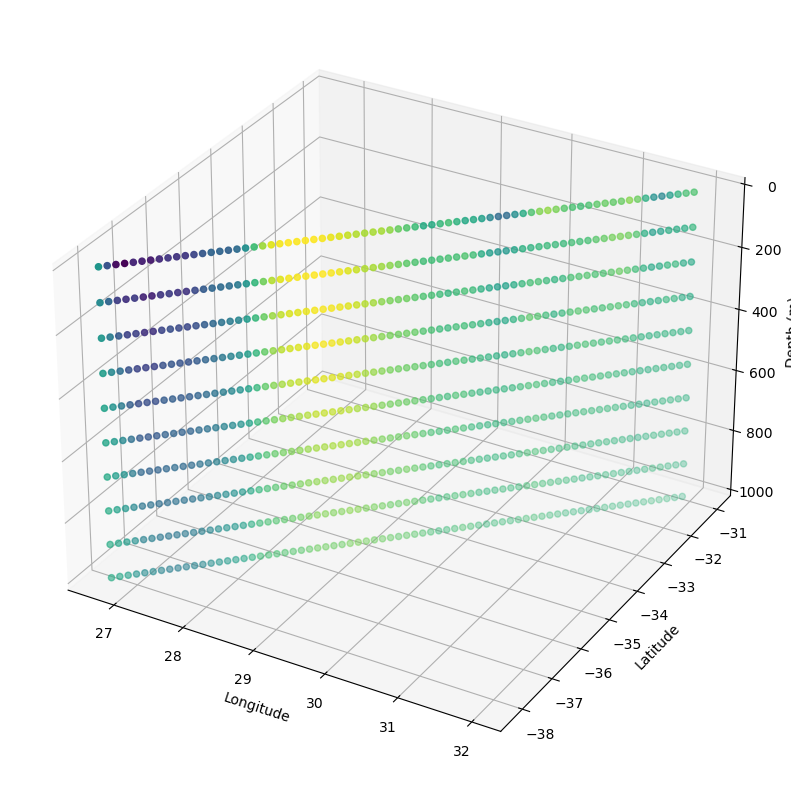

In [48]:
import matplotlib.pyplot as plt
import xarray as xr
from mpl_toolkits.mplot3d import Axes3D

# Open output and read to x, y, z
ds = xr.open_zarr("ADCPtest.zarr")
# ds = xr.open_zarr('tmp.zarr')
x = ds["lon"][:].squeeze()
y = ds["lat"][:].squeeze()
z = ds["z"][:].squeeze()
U = ds["U"][:].squeeze()
V = ds["V"][:].squeeze()
salinity = ds["salinity"][:].squeeze()
temperature = ds["temperature"][:].squeeze()
ds.close()

# Plot Particle depth
fig = plt.figure(figsize=(13, 10))
ax = plt.axes(projection="3d")
cb = ax.scatter(x, y, z, c=V, s=20, marker="o")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Depth (m)")
ax.set_zlim(np.max(z), 0)
plt.show()

In [45]:
print(ds)

<xarray.Dataset>
Dimensions:      (trajectory: 10, obs: 73)
Coordinates:
  * obs          (obs) int32 0 1 2 3 4 5 6 7 8 9 ... 64 65 66 67 68 69 70 71 72
  * trajectory   (trajectory) int64 80 81 82 83 84 85 86 87 88 89
Data variables:
    U            (trajectory, obs) float32 dask.array<chunksize=(10, 1), meta=np.ndarray>
    V            (trajectory, obs) float32 dask.array<chunksize=(10, 1), meta=np.ndarray>
    lat          (trajectory, obs) float32 dask.array<chunksize=(10, 1), meta=np.ndarray>
    lon          (trajectory, obs) float32 dask.array<chunksize=(10, 1), meta=np.ndarray>
    salinity     (trajectory, obs) float32 dask.array<chunksize=(10, 1), meta=np.ndarray>
    temperature  (trajectory, obs) float32 dask.array<chunksize=(10, 1), meta=np.ndarray>
    time         (trajectory, obs) datetime64[ns] dask.array<chunksize=(10, 1), meta=np.ndarray>
    z            (trajectory, obs) float32 dask.array<chunksize=(10, 1), meta=np.ndarray>
Attributes:
    Conventions:          